In [1]:
from tensorflow.keras.models import load_model
import pandas as pd
import pathlib
import tensorflow as tf
import os
import tensorflow.keras.applications     as     applications

In [2]:
from tensorflow.keras.models import Sequential

In [3]:
from tensorflow.keras.layers import Dropout

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('../utilities/')
from utilities import Timer, show_image, DreamImage, DeepDream

In [6]:
from utilities import ProgressBar

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
width = height = 224
batch_size = 32

In [9]:
# Load the classnames
df = pd.read_excel('../dataset/artist-breakdown-annotated.xlsx')
df = df[df.fillna(0).keep.astype(bool)]
class_names = df.artist.unique()
class_names.sort()

In [10]:
model_name = 'vgg19-INet-down2-b'
base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')

In [11]:
# Remove dropout
model = Sequential()
for layer in base_model.layers:
    if isinstance(layer, Dropout):
        pass
    else:
        model.add(layer)

In [12]:
# Load the list of file names in the form of data_dir/class_name/file_name.jpg
data_subdir = 'test'
data_dir = pathlib.Path('../dataset/images/') / pathlib.Path(data_subdir)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

dataset_size = len(list(list_ds))

In [13]:
# Function to get the label
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == class_names

# Function to get the image
def decode_img(file_path):
    # Load the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize
    return tf.image.resize(img, [width, height])

def preprocess_img(img, label):
    return applications.vgg19.preprocess_input(img), label

In [14]:
# Combine both processes
def process_path(file_path):
    return decode_img(file_path), get_label(file_path)

In [16]:
def classify_image(img_batch, label_batch):
    return model(img_batch), label_batch

In [17]:
# Create the dataset
ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
ds = ds.map(preprocess_img)
ds = ds.batch(batch_size).prefetch(buffer_size = AUTOTUNE)
ds = ds.map(classify_image)
ds = ds.cache()

In [18]:
bar = ProgressBar(dataset_size // batch_size + 1)

In [19]:
# class_batches = []
# label_batches = []
# bar.start()
# iterations = 0
# for class_batch, label_batch in ds:
#     class_batches.append(class_batch)
#     label_batches.append(label_batch)
#     iterations+=1
#     bar.update(iterations)

[==================================================] 92/92 6.9s per loop          


In [25]:
import numpy as np

In [40]:
# Convert to a single array
def concat_batches(batch_list):
    batch_list = [tensor.numpy() for tensor in batch_list]
    return np.concatenate(batch_list)

In [41]:
y_predict_proba = concat_batches(class_batches)

In [42]:
y_true = concat_batches(label_batches)

In [43]:
y_predict_proba

array([[6.8787444e-06, 2.7008873e-01, 5.2659019e-05, ..., 1.9147219e-02,
        1.1923209e-05, 8.4266598e-05],
       [1.1523705e-07, 3.0167470e-08, 1.2572187e-13, ..., 5.7557969e-12,
        1.2884237e-12, 5.9725575e-13],
       [6.4747382e-38, 6.9333416e-27, 0.0000000e+00, ..., 2.5962947e-32,
        5.3108383e-31, 5.0923994e-25],
       ...,
       [4.7731100e-06, 1.7051170e-02, 4.0145196e-06, ..., 3.5755936e-04,
        6.0648923e-05, 7.1528694e-03],
       [4.8821682e-01, 2.2256576e-07, 1.1620043e-05, ..., 1.9862457e-06,
        5.2968030e-13, 2.1412389e-11],
       [1.4898600e-03, 1.1549387e-02, 1.4818015e-03, ..., 8.0184964e-03,
        2.7073316e-05, 1.3258458e-03]], dtype=float32)

In [79]:
from utilities import plot_confusion_matrix

In [65]:
y_pred = []
for a in y_predict_proba:
    out = np.zeros(len(a))
    out[a.argmax()] = 1
    out = np.expand_dims(out, 0)
    y_pred.append(out)
y_pred = np.concatenate(y_pred)

In [73]:
y_pred_label = []
for a in y_predict_proba:
    out = class_names[a.argmax()]
    y_pred_label.append(out)

In [75]:
y_true_label = []
for a in y_true:
    out = class_names[a.argmax()]
    y_true_label.append(out)

In [76]:
from sklearn.metrics import classification_report

In [78]:
print(classification_report(y_true_label, y_pred_label))

                         precision    recall  f1-score   support

      Wassily Kandinsky       0.33      0.37      0.35        43
         Albrecht Durer       0.58      0.58      0.58       100
      Amedeo Modigliani       0.93      0.78      0.85        68
            Andy Warhol       0.26      0.30      0.28        37
           Claude Monet       0.73      0.72      0.72       100
             Cy Twombly       1.00      0.70      0.82        23
           Diego Rivera       0.43      0.38      0.41        26
        Diego Velazquez       0.23      0.26      0.25        27
            Edgar Degas       0.58      0.57      0.57        99
          Edouard Manet       0.19      0.24      0.21        46
           Edvard Munch       0.17      0.19      0.18        36
          Edward Hopper       0.71      0.38      0.49        32
           Egon Schiele       0.70      0.53      0.60        57
               El Greco       0.74      0.61      0.67        33
          Fernand Leger 

In [ ]:
plot_confusion_matrix()

In [80]:
from sklearn.metrics import confusion_matrix

In [82]:
# Get most confused

In [84]:
np.set_printoptions(threshold=np.inf)


In [99]:
cm = confusion_matrix(y_true_label, y_pred_label)

In [88]:
for i in range(cm.shape[0]):
    cm[i,i] = 0

In [92]:
cm.max(axis = 0).argmax()

20

In [94]:
cm.max()

25

In [95]:
cm[:,20].argmax()

38

In [96]:
cm[38,20]

25

In [97]:
class_names[38]

'Pablo Picasso'

In [98]:
class_names[20]

'Henri Matisse'

In [ ]:
plot_confusion_matrix()

In [101]:
import matplotlib.pyplot as plt

In [103]:
from sklearn.metrics import ConfusionMatrixDisplay

In [105]:
import seaborn as sns

In [106]:
sns.set()

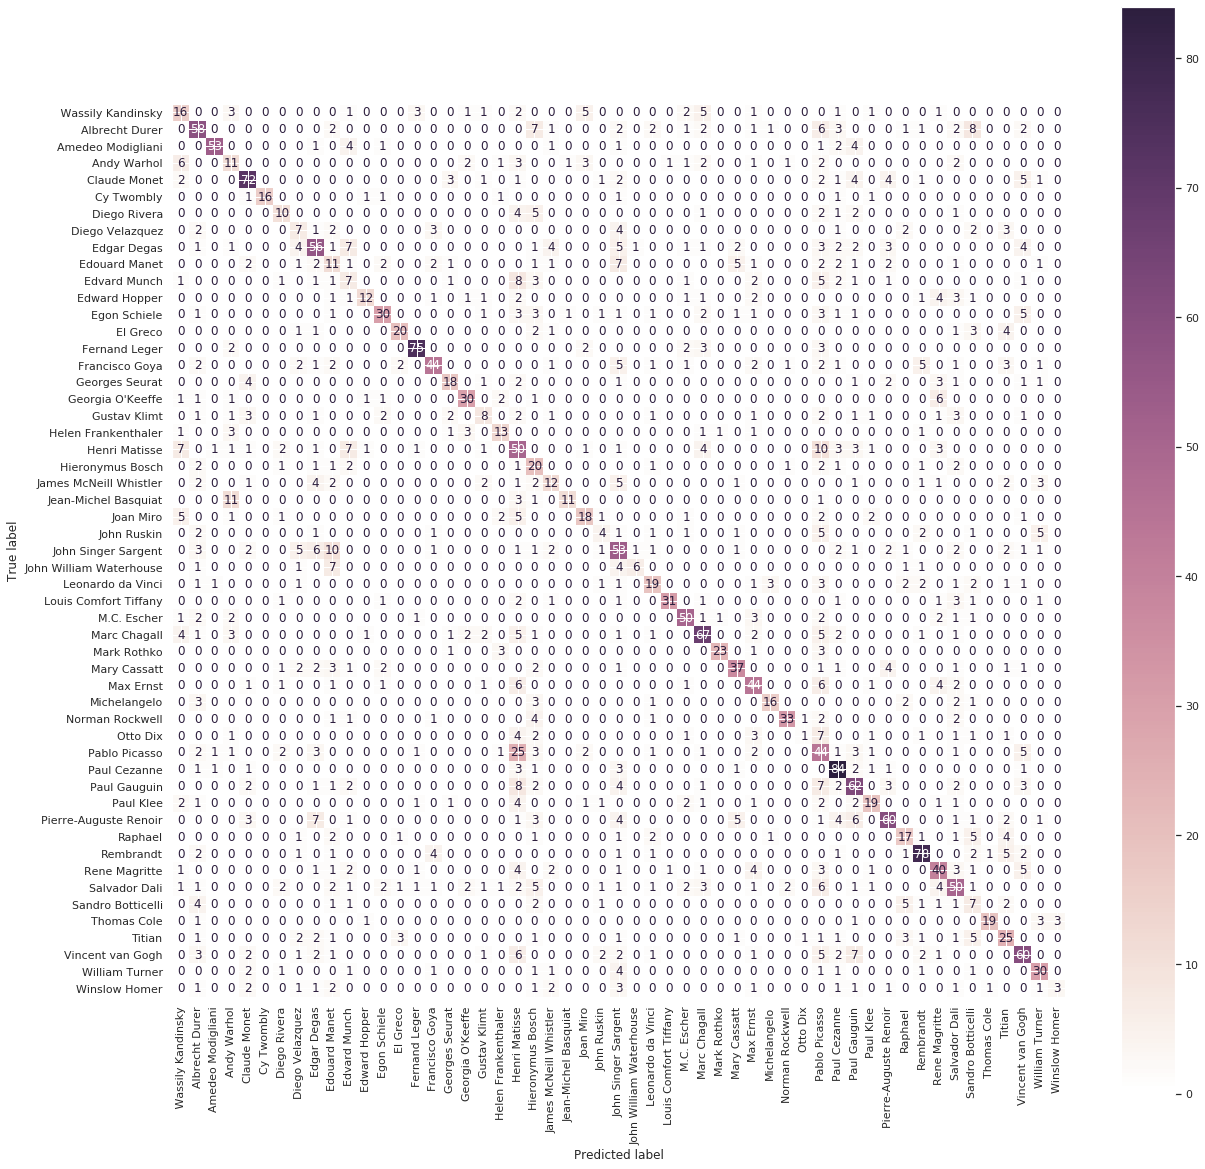

In [107]:
fig, ax = plt.subplots(figsize = (20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(include_values=True,
                 cmap=sns.cubehelix_palette(light=1, as_cmap=True), ax=ax, xticks_rotation='vertical')
plt.show()